# Brain time prediciton

This notebook demonstrates testing zero-shot predictions using the TimesFM model for time-series forecasting. The notebook also evaluates the performance of other forecasting methods for comparison, using control and patient time-series datasets.

## Imports
The following libraries are imported for data processing, visualization, and model training:
- `timesfm`: Implements the TimesFM model for forecasting.
- `pandas`: Handles dataset manipulation.
- `sktime`: Provides tools for forecasting and evaluation metrics.
- `sklearn`: Supplies preprocessing and regression tools.
- `numpy`: Used for mathematical operations.

In [1]:
import matplotlib.pyplot as plt
import timesfm
import pandas as pd
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_scaled_error, mean_absolute_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA, StatsForecastAutoETS
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import warnings

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.
Loaded PyTorch TimesFM.


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Supress convergence warnings from AutoARIMA

In [2]:
warnings.filterwarnings("ignore", message="possible convergence problem")

## TimesFM Model Initialization
The TimesFM model is initialized with GPU support and specific hyperparameters, including:
- Batch size: 32
- Forecast horizon: 128 steps

The model uses a pre-trained checkpoint from the HuggingFace repository.

In [3]:
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=128,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
  )

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 28926.23it/s]


## Control Data Analysis

### Data Loading
Control dataset is loaded from a `.tsv` file using a custom function, displaying basic statistics and structure.

In [4]:
def load_data(path, verbose = True):
    dataset = pd.read_csv(path, sep='\t', header = None)
    if verbose:
        print(dataset.columns)
        print(len(dataset))
        print(dataset.head())
    return dataset
control_data = load_data('data/subjects/control/sub-CON001_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv')

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype='int64')
333
         0         1         2         3         4         5         6   \
0  0.868193  0.573673  0.260477  0.189989 -0.111056  0.829825  0.739808   
1  3.383903  1.880025  1.246850  1.351163  1.009621  3.293502  1.876305   
2  4.372994  2.463648  1.765691  1.742092  1.734635  4.181486  1.629646   
3  3.134426  1.723929  1.411293  1.114747  1.883471  2.827912  0.019439   
4  1.522152  0.319903  0.459159  0.443271  1.832923  1.022122 -1.078747   

         7         8         9   ...        90        91        92        93  \
0

### Train-Test Split
The dataset is split into training and testing sets based on a predefined index.

In [5]:
def split_train_test(data, break_index):
    split = data.index < break_index
    return data[split], data[~split]
control_data_train, control_data_test = split_train_test(control_data, 300)

### TimesFM Forecast
Control training data is formatted for the TimesFM model, and predictions are generated for the testing set.

In [6]:
def convert_to_timefm(data):
    data_time_fm = []
    for col in data.columns:
        data_time_fm += [data[col]]
    return data_time_fm
control_data_train_for_time_fm = convert_to_timefm(control_data_train)

### Sample prediction using TimesFM

In [7]:
result = tfm.forecast(control_data_train_for_time_fm, freq=[0] * len(control_data_train.columns))[0]

### Evaluation
Predictions are evaluated using the following metrics:
- **Mean Absolute Error (MAE)**
- **Mean Absolute Percentage Error (MAPE)**

In [44]:
def evaluate_prediction(test, prediction):
    print(f"Mean absolute error {mean_absolute_error(test, prediction[:len(test)])}")
    print(f"Mean absolute procentage error {mean_absolute_percentage_error(test, prediction[:len(test)])}")

evaluate_prediction(control_data_test, result.T)

Mean absolute error 3.8349330707027445
Mean absolute procentage error 1.364473076049744


## Comparison with Other Methods
The following methods are applied to both control and patient datasets for comparison:
- **Naive Forecaster (Mean and Last strategies)**
- **Linear Regression**
- **StatsForecast AutoARIMA**
- **StatsForecast AutoETS**

Performance metrics are computed and compared across models.


### Sample prediction using Naive heuristic - mean

In [9]:
naive_mean = NaiveForecaster(strategy="mean")
fh = ForecastingHorizon(control_data_test.index, is_relative=False)

naive_mean.fit(control_data_train)
prediciton = naive_mean.predict(fh)

evaluate_prediction(control_data_test, prediciton)

Mean absolute error 3.782167809599197
Mean absolute procentage error 1.2026478269588585


### Sample prediction using Naive heuristic - last

In [10]:
naive_last = NaiveForecaster(strategy="last")
fh = ForecastingHorizon(control_data_test.index, is_relative=False)

naive_last.fit(control_data_train)
prediciton = naive_last.predict(fh)

evaluate_prediction(control_data_test, prediciton)

Mean absolute error 4.021051861760135
Mean absolute procentage error 3.160447606662448


### Sample prediction using LinearRegression

In [11]:
lr = make_reduction(LinearRegression(), window_length=len(control_data_test.index))
lr.fit(control_data_train, fh=fh)
prediciton = lr.predict()
evaluate_prediction(control_data_test, prediciton)

Mean absolute error 3.859021852457072
Mean absolute procentage error 2.1939933399038507


## Patient Data Analysis
The patient dataset is processed similarly:
- Data loading, train-test split, and normalization.
- Forecasts and evaluations using TimesFM and other methods.

In [12]:
patient_data = load_data('data/subjects/patient/sub-PAT024_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv')

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype='int64')
609
         0         1         2         3         4         5         6   \
0  1.482231 -0.423938  1.186617  0.701828  1.184446  1.542088  1.193000   
1 -0.322049 -0.514300  0.416168 -0.666232  0.183689  0.090434 -0.017942   
2 -2.666137 -0.302044 -1.151775 -1.775419 -1.303706 -2.254981 -1.627092   
3 -4.795990  0.422396 -2.714434 -2.468192 -2.483194 -4.291705 -3.046384   
4 -6.129407  1.297916 -3.412785 -2.721112 -2.886288 -4.899975 -3.616366   

         7         8         9   ...        90        91        92        93  \
0

In [13]:
patient_data_train, patient_data_test = split_train_test(patient_data, 550)

### Sample prediction using TimesFM

In [14]:
result = tfm.forecast(convert_to_timefm(patient_data_train), freq=[0] * len(patient_data_train.columns))[0]

In [15]:
evaluate_prediction(patient_data_test, result.T)

Mean absolute error 0.860730222821114
Mean absolute procentage error 1.7850505120587732


### Sample prediction using Naive heuristic - mean

In [16]:
naive_mean = NaiveForecaster(strategy="mean")
fh = ForecastingHorizon(patient_data_test.index, is_relative=False)

naive_mean.fit(patient_data_train)
prediciton = naive_mean.predict(fh)

evaluate_prediction(patient_data_test, prediciton)

Mean absolute error 0.8593008022054377
Mean absolute procentage error 1.2403224062764397


### Sample prediction using Naive heuristic - last

In [17]:
naive_last = NaiveForecaster(strategy="last")
fh = ForecastingHorizon(patient_data_test.index, is_relative=False)

naive_last.fit(patient_data_train)
prediciton = naive_last.predict(fh)

evaluate_prediction(patient_data_test, prediciton)

Mean absolute error 1.0264721065870996
Mean absolute procentage error 6.4619679355683095


### Sample prediction using LinearRegression

In [18]:
lr = make_reduction(LinearRegression(), window_length=len(patient_data_test.index))
lr.fit(patient_data_train, fh=fh)
prediciton = lr.predict()
evaluate_prediction(patient_data_test, prediciton)

Mean absolute error 0.8858769949248666
Mean absolute procentage error 2.1328362655462563


## Extended Evaluation Functions
Utility functions are implemented for automated evaluation:
- **Forecast plotting**: Visualizes actual vs. predicted data.
- **Metric aggregation**: Computes and summarizes MAE and MAPE across datasets.
- **Support for normalization**: Applies Min-Max and Standard scaling.

In [19]:
def return_score(test, prediction):
    return {"mae": mean_absolute_error(test, prediction[:len(test)]), "mape": mean_absolute_percentage_error(test, prediction[:len(test)])}

def plot_forecast(test, prediction, title):
    plt.figure(figsize=(10, 6))
    
    test_index = test.index
    prediction_index = test_index
    
    plt.plot(test_index, test[0], label="Actual Data", color='blue')
    plt.plot(prediction_index, prediction[0][:len(test)], label="Predicted Data", color='orange')

    plt.title(f"{title}\nComparison of Actual vs. Predicted Data")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

def train_lr_evaluate(control_data_train, control_data_test, plot_results=False):
    lr = make_reduction(LinearRegression(), window_length=len(control_data_test.index))
    fh = ForecastingHorizon(control_data_test.index, is_relative=False)
    lr.fit(control_data_train, fh=fh)
    prediction = lr.predict()
    score = return_score(control_data_test, prediction)

    if plot_results:
        plot_forecast(control_data_test, prediction, "Linear Regression Forecast")

    return score

def train_naive_evaluate(control_data_train, control_data_test, strategy, plot_results=False):
    naive_last = NaiveForecaster(strategy=strategy)
    fh = ForecastingHorizon(control_data_test.index, is_relative=False)
    naive_last.fit(control_data_train)
    prediction = naive_last.predict(fh)
    score = return_score(control_data_test, prediction)

    if plot_results:
        plot_forecast(control_data_test, prediction, f"NaiveForecaster {strategy} Forecast")

    return score

def train_timefm_evaluate(control_data_train, control_data_test, plot_results=False):
    control_data_train_for_time_fm = convert_to_timefm(control_data_train)
    result = tfm.forecast(control_data_train_for_time_fm, freq=[0] * len(control_data_train.columns))[0]
    score = return_score(control_data_test, result.T)

    if plot_results:
        plot_forecast(control_data_test, result.T, f"TimesFM Forecast")

    return score

def train_arima_evaluate(control_data_train, control_data_test, plot_results=False):
    arima_model = StatsForecastAutoARIMA(seasonal=False,
        with_intercept=True)
    fh = ForecastingHorizon(control_data_test.index, is_relative=False)
    arima_model.fit(control_data_train)
    prediction = arima_model.predict(fh)
    score = return_score(control_data_test, prediction)

    if plot_results:
        plot_forecast(control_data_test, prediction, "StatsForecast AutoARIMA Forecast")

    return score

def train_ets_evaluate(control_data_train, control_data_test, plot_results=False):
    ets_model = StatsForecastAutoETS(damped=True)
    fh = ForecastingHorizon(control_data_test.index, is_relative=False)
    ets_model.fit(control_data_train)
    prediction = ets_model.predict(fh)
    score = return_score(control_data_test, prediction)

    if plot_results:
        plot_forecast(control_data_test, prediction, "StatsForecast AutoETS Forecast")

    return score

def calculate_brak_index(data):
    if len(data) < 128 * 10:
        return int(0.9 * len(data))
    return len(data) - 128

def evaluate_for_path(path, scaler=None, include_arimas=True, plot_results=False):
    control_data = load_data(path, False)
    control_data_train, control_data_test = split_train_test(control_data, calculate_brak_index(control_data))
    if scaler:
        control_data_train, control_data_test = scaler(control_data_train, control_data_test)
    
    time_fm_result = train_timefm_evaluate(control_data_train, control_data_test, plot_results=plot_results)
    naive_mean_result = train_naive_evaluate(control_data_train, control_data_test, "mean", plot_results=plot_results)
    naive_last_result = train_naive_evaluate(control_data_train, control_data_test, "last", plot_results=plot_results)
    lr_result = train_lr_evaluate(control_data_train, control_data_test, plot_results=plot_results)
    if include_arimas:
        arima_result = train_arima_evaluate(control_data_train, control_data_test, plot_results=plot_results)
        ets_result = train_ets_evaluate(control_data_train, control_data_test, plot_results=plot_results)

        return {
            "time_fm": time_fm_result,
            "naive_mean": naive_mean_result,
            "naive_last": naive_last_result,
            "lr": lr_result,
            "arima": arima_result,
            "ets": ets_result
        }
    return {
        "time_fm": time_fm_result,
        "naive_mean": naive_mean_result,
        "naive_last": naive_last_result,
        "lr": lr_result,
    }

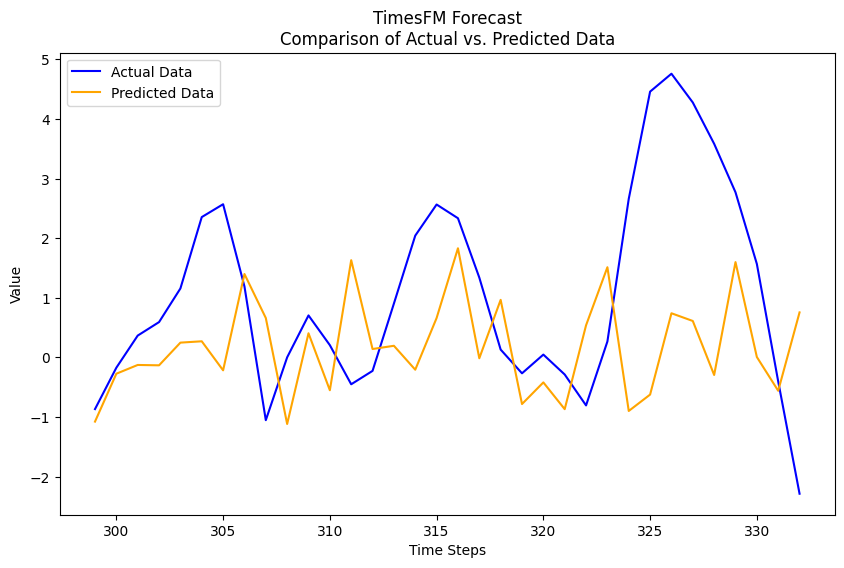

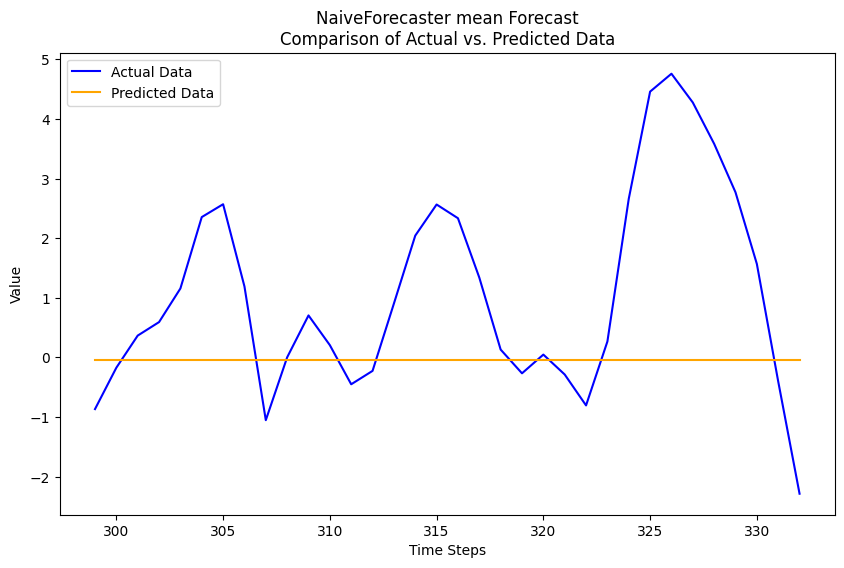

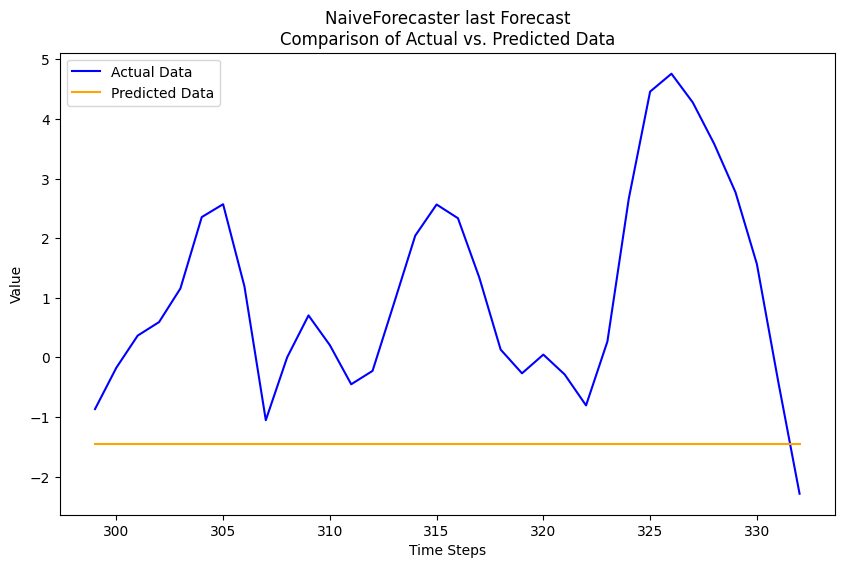

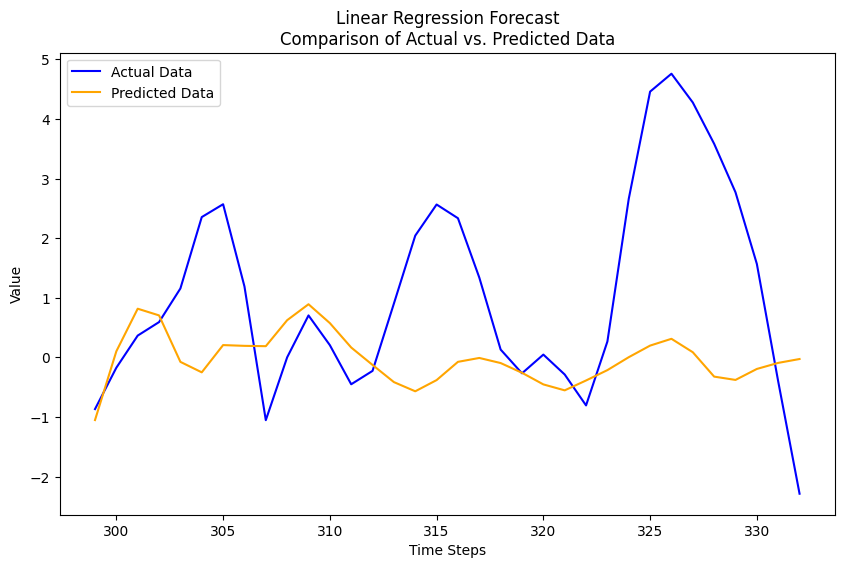

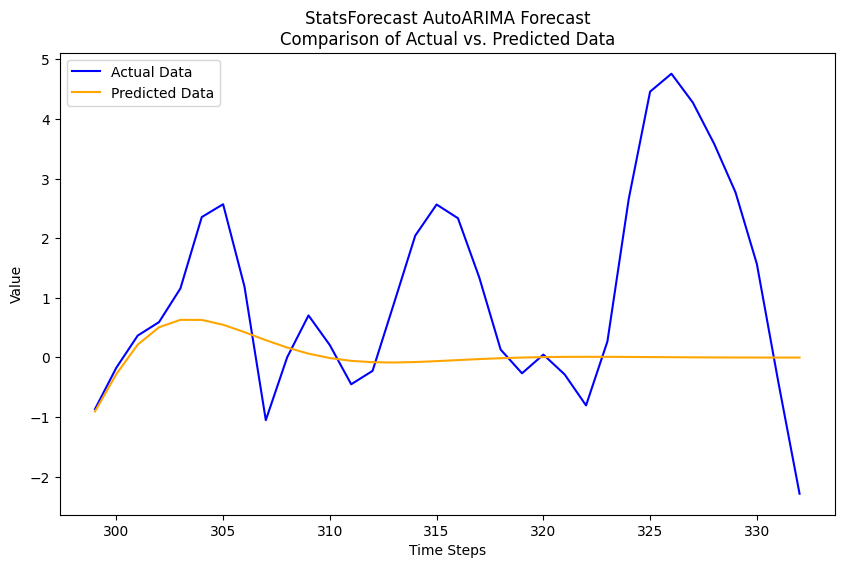

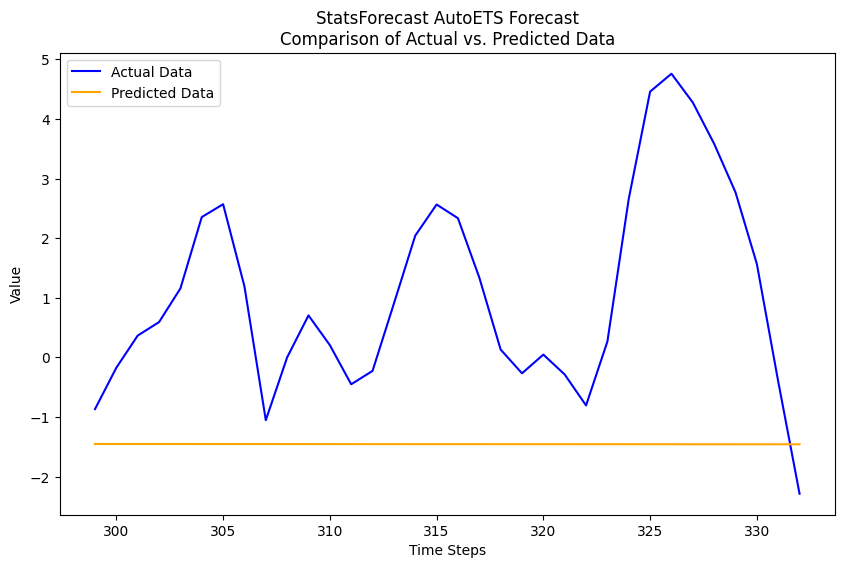

{'time_fm': {'mae': np.float64(3.6851368477079287),
  'mape': np.float64(2.0250007027256847)},
 'naive_mean': {'mae': np.float64(3.7040677221421423),
  'mape': np.float64(1.2064848379210713)},
 'naive_last': {'mae': np.float64(3.929177895963164),
  'mape': np.float64(3.2675437332258785)},
 'lr': {'mae': np.float64(3.8351615909478154),
  'mape': np.float64(2.3563811156161076)},
 'arima': {'mae': np.float64(3.6461155299123136),
  'mape': np.float64(1.4020592185567897)},
 'ets': {'mae': np.float64(3.9302280454629384),
  'mape': np.float64(3.267142475418117)}}

In [20]:
evaluate_for_path("data/subjects/control/sub-CON001_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv", scaler=None, include_arimas=True, plot_results=True)

## Analysis for Prediction Methods for sample data

### TimesFM Forecast
- TimesFM produces predictions with significant variability and larger magnitudes of changes compared to the actual data. While it dynamically adapts to fluctuations, many of the predicted changes appear to be noise rather than meaningful patterns. The model struggles with aligning the timing and magnitude of peaks and troughs.
- Strengths:
  - Dynamically adapts to changes in the data, avoiding flat predictions.
  - Captures the general upward and downward trends in the dataset.
- Weaknesses:
  - Introduces excessive noise, with many changes that do not align with actual data.
  - Fails to handle sharp transitions and extreme values accurately.
  - Timing and magnitude of predictions are frequently misaligned with actual peaks and troughs.

### Naive Forecaster (Mean Strategy)
- Predictions remain flat, corresponding to the mean of the training data, showing no variability.
- Strengths:
  - Simple and computationally inexpensive.
- Weaknesses:
  - Fails to capture any trends or patterns in the dataset.
  - Large deviation from actual data, particularly during peaks and troughs.

### Naive Forecaster (Last Strategy)
- Predictions are flat and based solely on the last observed value in the training set.
- Strengths:
  - Simplicity and low computational cost.
- Weaknesses:
  - Similar to the mean strategy, fails to adapt to the variability in the actual data.
  - Large errors at data points where significant changes occur.

### Linear Regression Forecast
- Linear regression captures the general trends in the data during initial time steps. However, it struggles to predict extreme fluctuations and fails to capture sharper peaks or troughs. The predictions are overly smoothed, leading to moderate errors.
- Strengths:
    - Performs better than naive methods by capturing broader trends in the data.
    - Maintains consistency in regions with steady transitions.
    - Compared to TimesFM, Linear Regression produces smoother and more stable predictions, avoiding the excessive noise introduced by TimesFM.
- Weaknesses:
    - Shows some divergence from actual data in highly dynamic regions.
    - Unlike TimesFM, Linear Regression misses many smaller fluctuations and predicts fewer changes overall, though the changes it predicts align better with actual rises.

### StatsForecast AutoARIMA
- AutoARIMA initially captures the starting trend in the data but quickly converges to predicting a constant value (close to 0) for the remainder of the prediction window. This behavior mirrors the Naive Forecaster (Mean Strategy) in later time steps, failing to capture fluctuations in the data.
- Strengths:
  - Handles the starting trend of the data better than naive methods.
- Weaknesses:
  - Predictions revert to a constant value after the initial trend.
  - Poor performance on non-stationary, dynamic data with rapid changes.
  - Results in significant errors when faced with fluctuations.

### StatsForecast AutoETS
- AutoETS produces predictions similar to the Naive Forecaster (Last Strategy), repeating the last observed value from the training data across the prediction window. This behavior shows that AutoETS fails to capture any underlying patterns or trends in the data.
- Strengths:
  - Simple implementation for stationary datasets.
- Weaknesses:
  - Predictions are constant and mimic the Naive Last strategy.
  - Fails to adapt to changes or trends in non-stationary, dynamic data.
  - Offers no advantage over simpler naive methods in this case.

### Evaluating All Files in a Folder

The function `evaluete_all_files` processes all files in the specified folder, excluding `.ipynb_checkpoints`.

In [21]:
def evaluete_all_files(folder_path, scaler=None, include_arimas=True, plot_results=False):
    acc = {}
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            relative_path = os.path.relpath(os.path.join(root, file), start=folder_path)
            if relative_path.startswith(".ipynb_checkpoints"):
                continue
            print(relative_path)
            acc[file] = evaluate_for_path(f"{folder_path}/{relative_path}", scaler=scaler, include_arimas=include_arimas, plot_results=plot_results)
    return acc

## Process all control files

In [22]:
control_folder_result = evaluete_all_files("data/subjects/control", scaler=None, include_arimas=True, plot_results=False)
control_folder_result

sub-CON005_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON007_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON001_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON002_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON011_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON003_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON009_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON008_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON006_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON012_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv


{'sub-CON005_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv': {'time_fm': {'mae': np.float64(1.7613791101903467),
   'mape': np.float64(16.469247093404846)},
  'naive_mean': {'mae': np.float64(1.8911993382978958),
   'mape': np.float64(9.8048123483675)},
  'naive_last': {'mae': np.float64(2.0174614577971957),
   'mape': np.float64(33.58819479864674)},
  'lr': {'mae': np.float64(2.129071057326691),
   'mape': np.float64(29.602429447526177)},
  'arima': {'mae': np.float64(2.2308172621995777),
   'mape': np.float64(21.868231462609447)},
  'ets': {'mae': np.float64(2.240996526413572),
   'mape': np.float64(26.929994940786145)}},
 'sub-CON007_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv': {'time_fm': {'mae': np.float64(0.755574321471056),
   'mape': np.float64(1.6799208334708)},
  'naive_mean': {'mae': np.float64(0.7613411647649495),
   'mape': np.float64(1.2261773196676833)},
  'naive_last': {'mae': np.float64(0.97228848

## Process all patient files

In [23]:
patient_folder_result = evaluete_all_files("data/subjects/patient", scaler=None, include_arimas=True, plot_results=False)
patient_folder_result

sub-PAT028_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT026_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT032_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT031_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT024_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT030_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT029_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT033_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT027_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT034_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv


{'sub-PAT028_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv': {'time_fm': {'mae': np.float64(0.5653328021994778),
   'mape': np.float64(3.2343051471938793)},
  'naive_mean': {'mae': np.float64(0.5022545257402262),
   'mape': np.float64(3.1103717747705617)},
  'naive_last': {'mae': np.float64(0.5548196669425834),
   'mape': np.float64(3.8608224677474077)},
  'lr': {'mae': np.float64(0.5636134952280956),
   'mape': np.float64(4.151662061387886)},
  'arima': {'mae': np.float64(0.49706240083155656),
   'mape': np.float64(2.2930090892756763)},
  'ets': {'mae': np.float64(0.5549226059984096),
   'mape': np.float64(3.862350889600928)}},
 'sub-PAT026_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv': {'time_fm': {'mae': np.float64(1.687757011830111),
   'mape': np.float64(2.674741402123461)},
  'naive_mean': {'mae': np.float64(1.6374298885960292),
   'mape': np.float64(2.133714961438376)},
  'naive_last': {'mae': np.float64(2.129975

### Extracting Accuracy Results

The function `acc_result` extracts the evaluation results for a specific model and metric from a folder's evaluation results.

In [24]:
def acc_result(folder_result, model_name, metric):
    acc = []
    for folder_name in folder_result.keys():
        acc.append(folder_result[folder_name][model_name][metric])
    return acc

In [25]:
acc_result(control_folder_result, "time_fm", "mape")

[np.float64(16.469247093404846),
 np.float64(1.6799208334708),
 np.float64(2.0250007027256847),
 np.float64(2.200152663616163),
 np.float64(8.730513170089736),
 np.float64(15.122182839520692),
 np.float64(2.1639707847667617),
 np.float64(2.2122217464862053),
 np.float64(4.348142256737225),
 np.float64(2.2975123347999866)]

### Calculating Mean and Variance

The function `calculate_mean_and_variance` computes the mean and variance of a given list of numbers.

In [26]:
def calculate_mean_and_variance(numbers):
    array = np.array(numbers)
    mean = np.mean(array)
    variance = np.var(array)
    
    return mean, variance

In [27]:
calculate_mean_and_variance(acc_result(control_folder_result, "time_fm", "mape"))

(np.float64(5.72488644256181), np.float64(29.392015828866676))

## Model Comparisons
### Metrics Analysis
Mean and variance of MAPE are calculated for each model:
- Results are visualized with bar charts comparing models.
- Separate analyses for control and patient datasets.

In [28]:
models = ["time_fm", "lr", "naive_mean", "naive_last", "arima", "ets"]

### Mean absolute procentage error - mean and variance for control timeseries

In [ ]:
def compare_models(folder_result, models):
    means = []
    variances = []

    for m in models:
        mean, var = calculate_mean_and_variance(acc_result(folder_result, m, "mape"))
        means.append(mean)
        variances.append(var)
        print(f"{m}: Mean MAPE: {mean:.2f}, Variance: {var:.2f}")
    
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(models, means, color='skyblue')
    plt.title("Mean MAPE for Each Model")
    plt.ylabel("Mean MAPE")
    plt.xlabel("Models")

    plt.subplot(1, 2, 2)
    plt.bar(models, variances, color='orange')
    plt.title("Variance of MAPE for Each Model")
    plt.ylabel("Variance")
    plt.xlabel("Models")

    plt.tight_layout()
    plt.show()

time_fm: Mean MAPE: 5.72, Variance: 29.39
lr: Mean MAPE: 13.24, Variance: 505.66
naive_mean: Mean MAPE: 8.95, Variance: 338.54
naive_last: Mean MAPE: 14.15, Variance: 145.13
arima: Mean MAPE: 3.90, Variance: 37.08
ets: Mean MAPE: 13.48, Variance: 123.34


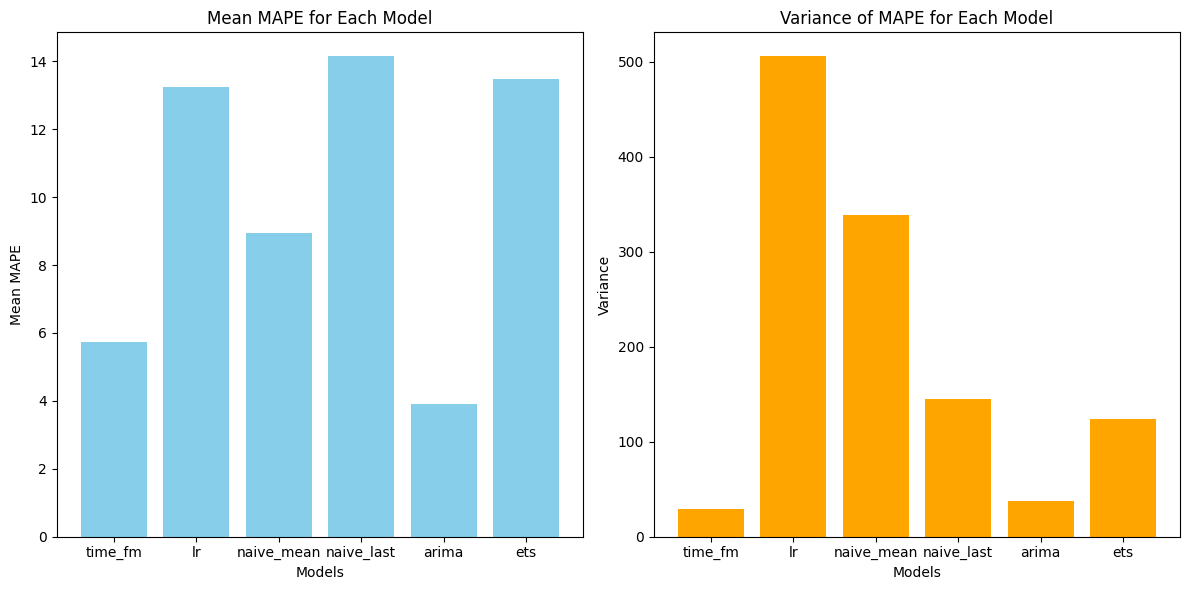

In [30]:
compare_models(control_folder_result, models)

#### Results for Control Dataset with Raw Data

TimesFM achieves a low mean error and the lowest variance, indicating stable and accurate predictions.

ARIMA performs best in terms of mean error but has slightly higher variance than TimesFM.

Linear Regression has high error and the highest variance, showing inconsistent predictions.

Naive Mean and Naive Last perform poorly, with Naive Last showing the highest mean error.

ETS also struggles with high error and moderate variance.

Overall, ARIMA and TimesFM stand out, with ARIMA providing the most accurate predictions.

### Mean absolute procentage error - mean and variance for patient timeseries

time_fm: Mean MAPE: 2.76, Variance: 4.40
lr: Mean MAPE: 67.44, Variance: 36999.77
naive_mean: Mean MAPE: 4.10, Variance: 28.05
naive_last: Mean MAPE: 6.31, Variance: 2.75
arima: Mean MAPE: 6.13, Variance: 197.46
ets: Mean MAPE: 6.25, Variance: 2.79


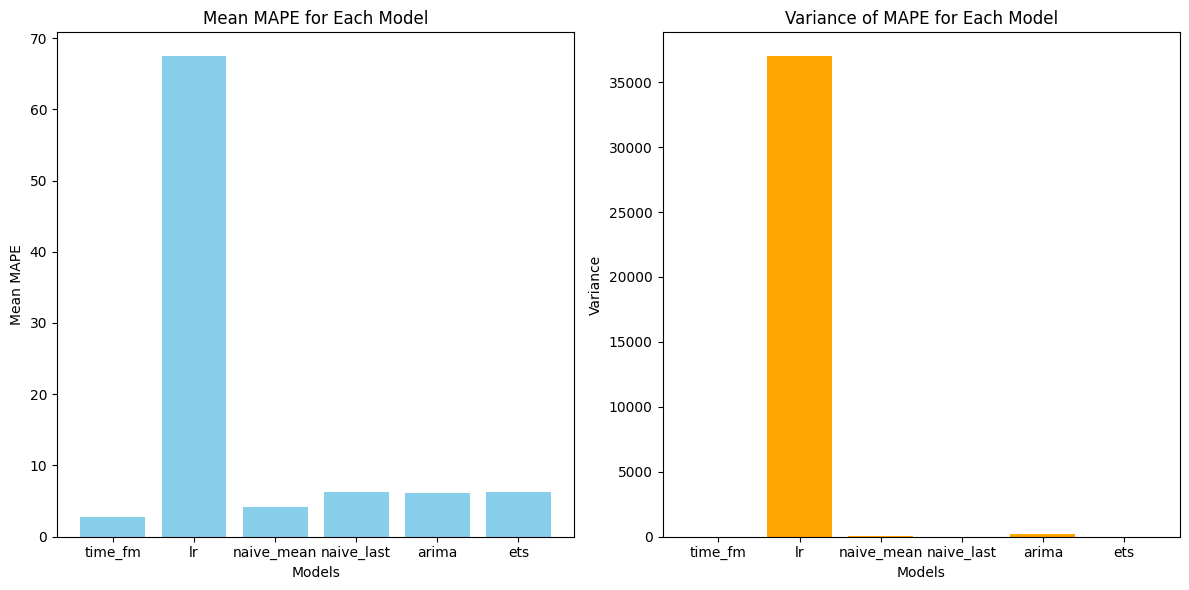

In [31]:
compare_models(patient_folder_result, models)

#### Results for Patient Dataset with Raw Data

TimesFM delivers the lowest mean error, demonstrating the best accuracy overall, but its variance is slightly higher than Naive Last and ETS.

Linear Regression performs the worst, with extremely high error and variance, making it highly unreliable.

Naive Mean shows moderate mean error but higher variance than TimesFM.

Naive Last and ETS have comparable mean errors and the lowest variances, but their accuracy remains poor.

ARIMA struggles with higher variability and moderate error. While TimesFM provides the most accurate predictions, Naive Last and ETS are more consistent but less reliable in terms of accuracy.

## Normalization Effects
The impact of normalization on forecasting performance is evaluated. Results for both Min-Max and Standard scaling are computed and visualized

In [32]:
def min_max_scaler(control_data_train, control_data_test):
    minmax_scaler = MinMaxScaler()
    train_index = control_data_train.index
    test_index = control_data_test.index
    control_data_train = minmax_scaler.fit_transform(control_data_train)
    control_data_test = minmax_scaler.transform(control_data_test)
    return pd.DataFrame(control_data_train, index = train_index), pd.DataFrame(control_data_test, index = test_index)

In [33]:
def standard_scaler(control_data_train, control_data_test):
    standard_scaler = StandardScaler()
    train_index = control_data_train.index
    test_index = control_data_test.index

    control_data_train_scaled = standard_scaler.fit_transform(control_data_train)

    control_data_test_scaled = standard_scaler.transform(control_data_test)

    return (
        pd.DataFrame(control_data_train_scaled, index=train_index, columns=control_data_train.columns),
        pd.DataFrame(control_data_test_scaled, index=test_index, columns=control_data_test.columns)
    )

In [34]:
evaluate_for_path("data/subjects/control/sub-CON001_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv", scaler=min_max_scaler, include_arimas=True, plot_results=False)

{'time_fm': {'mae': np.float64(0.3625050985400825),
  'mape': np.float64(0.5829836876819092)},
 'naive_mean': {'mae': np.float64(0.36522996517613265),
  'mape': np.float64(0.594060038894035)},
 'naive_last': {'mae': np.float64(0.39267057217967344),
  'mape': np.float64(0.6140120471337076)},
 'lr': {'mae': np.float64(0.3714010104958685),
  'mape': np.float64(0.5934624276402961)},
 'arima': {'mae': np.float64(0.3600453559433355),
  'mape': np.float64(0.5741618617529088)},
 'ets': {'mae': np.float64(0.3927200881833403),
  'mape': np.float64(0.6141188756869954)}}

### Min-max normalization - Mean absolute procentage error - mean and variance for control timeseries

sub-CON005_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON007_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON001_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON002_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON011_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON003_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON009_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON008_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON006_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON012_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
time_fm: Mean MAPE: 0.55, Variance: 0.42
lr: Mean MAPE: 0.59, Variance: 0.51
nai

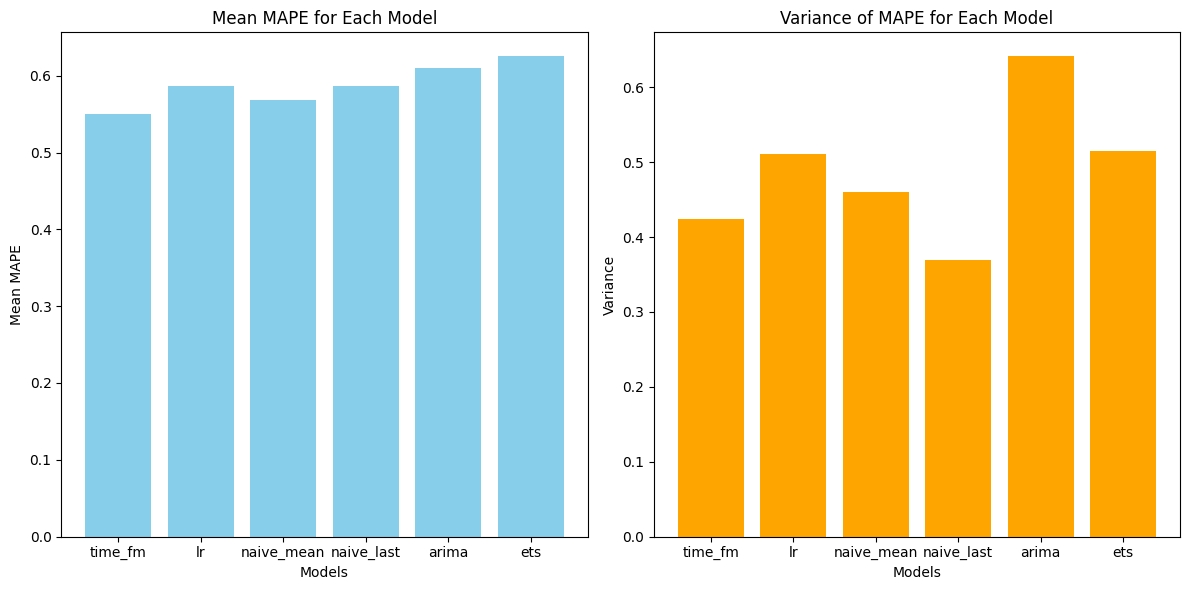

In [35]:
control_folder_result_normal = evaluete_all_files("data/subjects/control", scaler=min_max_scaler, include_arimas=True, plot_results=False)
compare_models(control_folder_result_normal, models)

#### Results for Control Dataset After Min-Max Normalization

After min-max normalization, the mean errors and variances for all models are reduced, but this might reflect the effect of scaling rather than an actual improvement in performance.

TimesFM achieves the lowest mean error, demonstrating strong accuracy, but Naive Last has the lowest variance, indicating higher consistency.

Naive Mean and Linear Regression perform similarly, with slightly higher mean errors and variances compared to TimesFM.

ARIMA has avarage mean error and the highest variance, showing the least stable performance.

ETS has the worst avarage mean error.

Overall, TimesFM remains the most accurate, while Naive Last shows the most consistent predictions.

### Min-max normalization - Mean absolute procentage error - mean and variance for patient timeseries

sub-PAT028_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT026_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT032_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT031_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT024_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT030_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT029_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT033_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT027_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT034_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
time_fm: Mean MAPE: 0.27, Variance: 0.01
lr: Mean MAPE: 0.59, Variance: 0.76
naive_mean: Mean MAPE: 

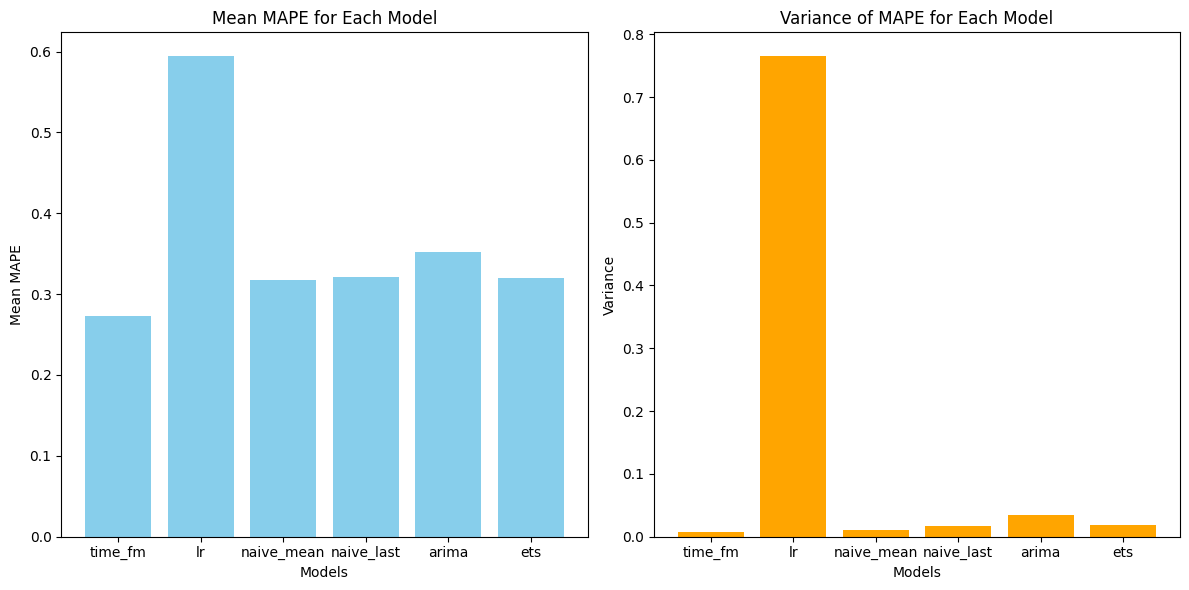

In [36]:
patient_folder_result_normal = evaluete_all_files("data/subjects/patient", scaler=min_max_scaler, include_arimas=True, plot_results=False)
compare_models(patient_folder_result_normal, models)

#### Results for Patient Dataset After Min-Max Normalization

After scaling, TimesFM achieves the lowest mean error and variance, making it the most accurate and consistent model overall.

Naive Mean, Naive Last, and ETS show comparable mean errors slightly higher than TimesFM, with minimal variance, indicating stable but less accurate predictions.

ARIMA has a higher mean error and variance, reflecting less stability.

Linear Regression shows the poorest performance, with the highest variance and a mean error significantly larger than other models.

While the scaled metrics cannot directly imply better performance, TimesFM's results stand out for both accuracy and consistency under normalization.


### Standard normalization - Mean absolute procentage error - mean and variance for control timeseries

sub-CON005_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON007_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON001_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON002_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON011_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON003_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON009_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON008_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON006_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-CON012_ses-control_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
time_fm: Mean MAPE: 4.87, Variance: 40.27
lr: Mean MAPE: 3.84, Variance: 6.88
na

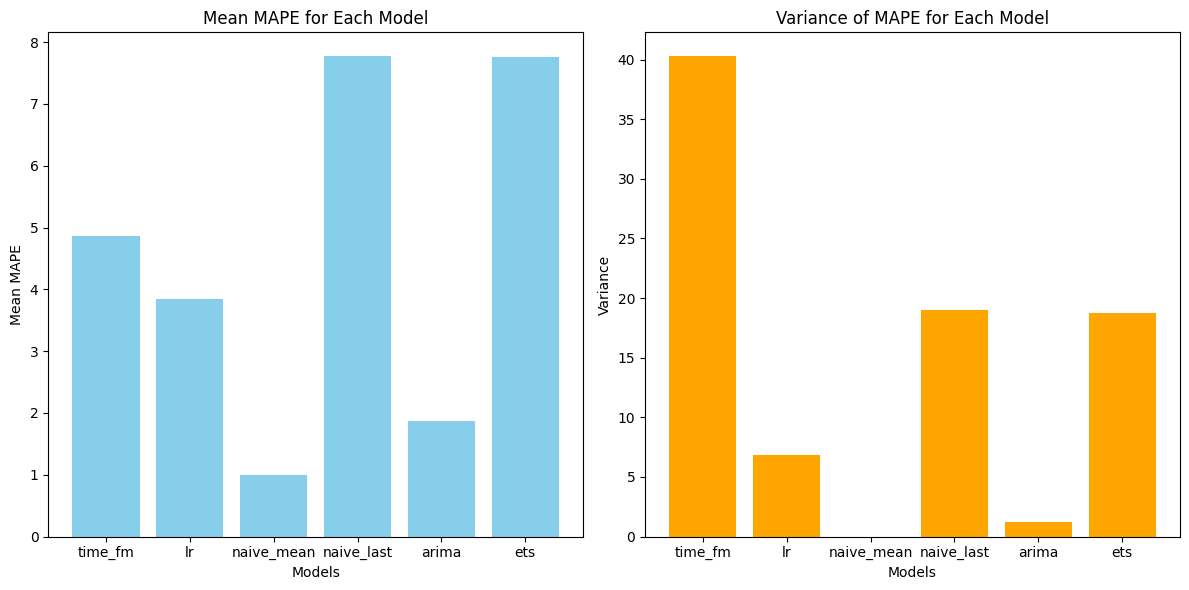

In [37]:
control_folder_result_normal = evaluete_all_files("data/subjects/control", scaler=standard_scaler, include_arimas=True, plot_results=False)
compare_models(control_folder_result_normal, models)

### Results for Control Dataset After Standard Scaling

After applying standard scaling, Naive Mean achieves the lowest mean error and an extremely low variance, which suggests that the errors across the dataset are nearly identical. This result is surprising and unlikely unless the dataset itself is highly uniform or constant in nature, as Naive Mean predicts a single average value throughout.

ARIMA performs well, showing low mean error and small variance, indicating stable and accurate predictions. Linear Regression also demonstrates good performance, with a mean error close to ARIMA's and low variance, reflecting consistent predictions.

TimesFM, while dynamically capturing trends, shows a higher mean error and variance compared to ARIMA and Linear Regression, reflecting less stability and accuracy. Naive Last and ETS perform poorly, with high mean errors and moderately high variances, indicating struggles to adapt effectively to the scaled data.

### Standard normalization - Mean absolute procentage error - mean and variance for patient timeseries

sub-PAT028_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT026_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT032_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT031_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT024_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT030_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT029_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT033_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT027_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
sub-PAT034_ses-acute_task-rest_space-MNI152NLin2009cAsym_atlas-Schaefer117_timeseries.tsv
time_fm: Mean MAPE: 3.56, Variance: 5.10
lr: Mean MAPE: 9.11, Variance: 157.34
naive_mean: Mean MAPE

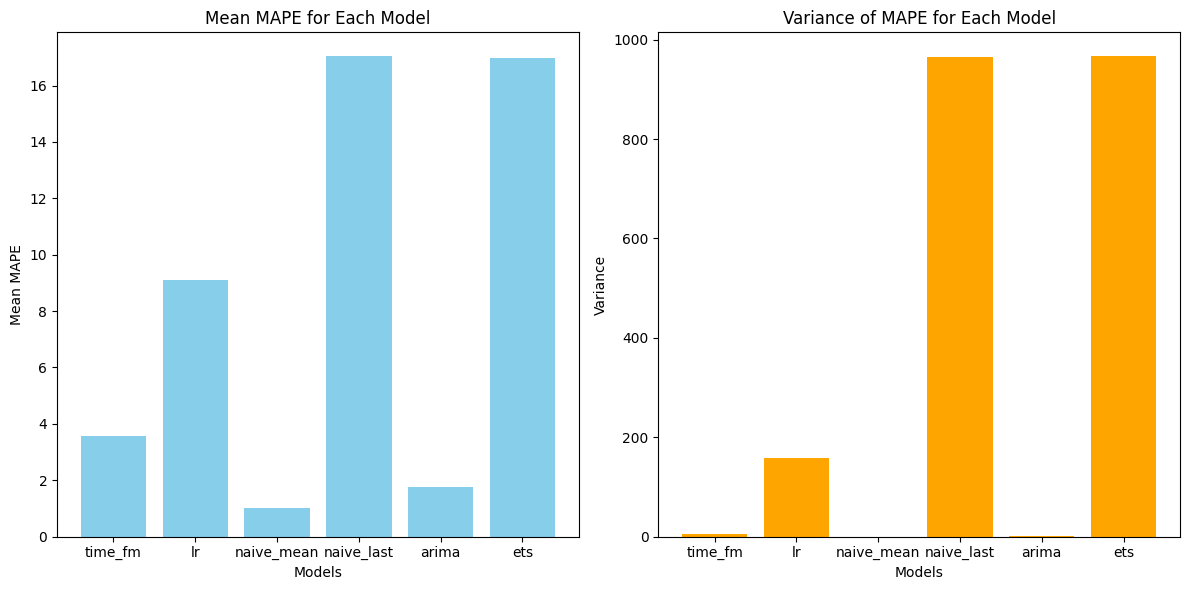

In [38]:
patient_folder_result_normal = evaluete_all_files("data/subjects/patient", scaler=standard_scaler, include_arimas=True, plot_results=False)
compare_models(patient_folder_result_normal, models)

#### Results for Patient Dataset After Standard Scaling

After applying standard scaling, Naive Mean achieves the lowest mean error and a variance of zero.

ARIMA performs well, with a low mean error and small variance, indicating stable and accurate predictions. TimesFM shows moderate performance, with a mean error higher than ARIMA but still significantly better than other models, and a manageable variance indicating reasonable stability.

Linear Regression shows weaker performance, with a higher mean error and variance compared to ARIMA and TimesFM, indicating less consistent predictions. Naive Last and ETS perform poorly, with the highest mean errors and variances among all models, reflecting significant struggles to adapt to the scaled dataset.

## Stationarity Test
The stationarity of the data is tested using the Augmented Dickey-Fuller (ADF) test:
- Displays ADF statistic, p-value, and critical values.
- Determines if the data is stationary based on the p-value.

In [39]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data):
    result = adfuller(data)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])

    if result[1] <= 0.05:
        print("The data is stationary.")
        return True
    else:
        print("The data is NOT stationary.")
        return False

In [40]:
is_stationary = test_stationarity(control_data_train.iloc[:, 0])

ADF Statistic: -10.41853977993009
p-value: 1.728754272631439e-18
Critical Values: {'1%': np.float64(-3.4524859843440754), '5%': np.float64(-2.871288184343229), '10%': np.float64(-2.571964047565425)}
The data is stationary.


The ADF test confirms the data is stationary, as the p-value is much smaller than 0.05 and the ADF statistic is lower than the critical values. Since ARIMA models are designed for stationary data, their use is justified here. Stationarity ensures ARIMA can effectively capture temporal patterns without requiring additional transformations.